# PDSCH Waveform generation
Creating PDSCH time domain waveform and comparing the results with the equivalent Matlab code "MatlabFiles/PDSCH-waveform.mlx". [Here](MatlabFiles/PDSCH-waveform.html) is the execution results of this code in Matlab.

In [1]:
import numpy as np
import scipy.io

from neoradium import Carrier, PDSCH, CdlChannel, AntennaPanel, LdpcEncoder, LdpcDecoder, Grid

matlabFilesPath = "./MatlabFiles"


## Carrier Configuration
Create an instance of `Carrier` object. We use 30KHz subcarrier spacing, with a single Bandwidth Part starting at Resource Block 1, and 52 total Resource Blocks. We then call the `print` method to show the carrier information.

In [2]:
carrier = Carrier(startRb=1, numRbs=52, spacing=30)
carrier.print()


Carrier Properties:
  startRb: 1
  numRbs: 52
  Cell Id: 1
  Active Bandwidth Part: 0
  Bandwidth Parts: 1
  Bandwidth Part 0:
    Resource Blocks: 52 RBs starting at 1 (624 subcarriers)
    Subcarrier Spacing: 30 KHz
    CP Type: normal
    bandwidth: 18720000 Hz
    symbolsPerSlot: 14
    slotsPerSubFrame: 2
    nFFT: 1024



## PDSCH Configuration
Create an instance of `PDSCH` object. We use the only Bandwidth Part of the above carrier for this PDSCH object. We then, enable the interleaving by setting the `interleavingBundleSize` argument to 2 and set number of layers to 2. The `print` function is then called to show all the information about this `PDSCH` object.

Note that we could also set the parameters of `DMRS` object owned by `PDSCH` by passing them when instantiating the `PDSCH` object. Here we are just using the default values.

Also note that the Matlab implementation does not take into account the scaling factor $ \beta^{DMRS}_{PDSCH} $ as specified in newer versions of the standard. Our implementation by default uses the `TS 38.214 V17.0.0 (2021-12), Table 4.1-1` to get the ratio of PDSCH EPRE to DMRS EPRE ($ \beta_{DMRS} $). To make our results match Matlab's results, we have to force the `epreRatioDb` value to zero here to ignore the table in the standard.

In [3]:
pdsch = PDSCH(carrier.bwps[0], interleavingBundleSize=2, numLayers=2)
# Matlab uses NumCDMGroupsWithoutData=2 as default => otherCdmGroups=[1]
pdsch.setDMRS(epreRatioDb=0, otherCdmGroups=[1])
pdsch.print()


PDSCH Properties:
  mappingType: A
  nID: 1
  rnti: 1
  numLayers: 2
  numCodewords: 1
  modulation: 16QAM
  portSet: [0, 1]
  symSet:   0   1   2   3   4   5   6   7   8   9  10  11  12  13
  prbSet:   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
           20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
           40  41  42  43  44  45  46  47  48  49  50  51
  interleavingBundleSize: 2
  PRG Size: Wideband
  Bandwidth Part:
    Resource Blocks: 52 RBs starting at 1 (624 subcarriers)
    Subcarrier Spacing: 30 KHz
    CP Type: normal
    bandwidth: 18720000 Hz
    symbolsPerSlot: 14
    slotsPerSubFrame: 2
    nFFT: 1024
  DMRS:
    configType: 1
    nIDs: []
    scID: 0
    sameSeq: 1
    symbols: Single
    typeA1stPos: 2
    additionalPos: 0
    cdmGroups: [0, 0]
    deltaShifts: [0, 0]
    allCdmGroups: [0, 1]
    symSet: [2]
    REs (before shift): [0, 2, 4, 6, 8, 10]
    epreRatioDb: 0 (db)



## Create a grid and populate it with DMRS data
Now we can create a resource grid (A `Grid` object) for our `PDSCH` and populate it with DMRS data.

In [4]:
grid = pdsch.getGrid()   # This creates a Grid object and populates it with the DMRS values
grid.shape

(2, 14, 624)

## Comparing DMRS symbols
Now we want to compare the DMRS symbols generated by our `PDSCH` object with Matlab's results. Again, we first get the indexes of the DMRS symbols from the grid map. Then we get the symbols at this indexes. We then print out the first 10 DMRS symbols. We can now compare these results with the ones printed by the Matlab program `Mapping5GPhysicalChannelsAndSignalsToTheResourceGridExample.mlx`.

In [5]:
dmrsSymbols = grid.getReValues("DMRS")  # Get all the "DMRS" Resource Element values from the grid

# Load Matlab-generated DMRS values:
dmrsSymbolsMatlab = scipy.io.loadmat(matlabFilesPath + '/dmrsSymbols.mat')['dmrsSymbols'].T.flatten()
assert np.abs(dmrsSymbolsMatlab-dmrsSymbols).max()<1e-10, "MISMATCH WITH MATLAB!!!"

# Print the first 10 DMRS Symbols:
print("DMRS Values:\n",dmrsSymbols[:10])
print("Matlab-Generated DMRS Values:\n",dmrsSymbolsMatlab[:10])

DMRS Values:
 [ 0.70710678-0.70710678j  0.70710678+0.70710678j  0.70710678-0.70710678j
 -0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678+0.70710678j
  0.70710678+0.70710678j  0.70710678+0.70710678j  0.70710678+0.70710678j
  0.70710678+0.70710678j]
Matlab-Generated DMRS Values:
 [ 0.70710678-0.70710678j  0.70710678+0.70710678j  0.70710678-0.70710678j
 -0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678+0.70710678j
  0.70710678+0.70710678j  0.70710678+0.70710678j  0.70710678+0.70710678j
  0.70710678+0.70710678j]


## Generate random bits and create resource block
Here we first get the number of bits that are available in our `grid` object by calling the `getGridBitSize` method. Then we creare `numBits` random bits and feed them to the `populateGrid` method of `PDSCH`. This method scrambles, modulates, and map the modulated symbols to different layers of the grid.

**Note**: To have deterministic results and be able to compare the results with matlab, we are reading the random bits from a Matlab-generated data file. You can un-remark the second line in the code below to create random bits instead of reading them from the file. 

In [6]:
numBits = pdsch.getBitSizes(grid)
# bits = np.random.randint(2,size=numBits)  # Unremark this to generate random bits

# Loading the random bits from file to have deterministic resaults and be able to compare with matlab
bits = scipy.io.loadmat(matlabFilesPath + '/pdschBits.mat')['pdschBits'].flatten()
assert(numBits[0] == len(bits))

pdsch.populateGrid(grid, bits)

## Comparing the results with Matlab
Now we want to compare the generated symbols with the Matlab's results. We first get the data symbols from the `pdsch` object's `getDataSymbols` method which returns all data symbols in the grid. 

We then read all the Matlab-generated symbols (from the same random set of bits) from the file generated by the Matlab program `Mapping5GPhysicalChannelsAndSignalsToTheResourceGridExample.mlx`. 

As you can see the results exactly matches the ones generated by Matlab.

In [7]:
dataSymbols = pdsch.getDataSymbols(grid)

dataSymbolsMatlab = scipy.io.loadmat(matlabFilesPath + '/pdschSymbols.mat')['pdschSymbols'].T.flatten()
assert np.abs(dataSymbolsMatlab-dataSymbols).max()<1e-10, "MISMATCH WITH MATLAB!!!"

# Print the first 20 Data Symbols:
print("Data Symbols:\n", dataSymbols[:20])
print("Matlab-Generated Data Symbols:\n", dataSymbolsMatlab[:20])

Data Symbols:
 [ 0.31622777+0.31622777j -0.9486833 -0.9486833j  -0.9486833 -0.31622777j
 -0.31622777-0.31622777j  0.31622777-0.31622777j  0.9486833 +0.9486833j
  0.9486833 +0.31622777j -0.9486833 -0.9486833j  -0.9486833 +0.9486833j
 -0.31622777+0.31622777j  0.9486833 +0.31622777j -0.9486833 -0.9486833j
  0.9486833 -0.9486833j  -0.31622777+0.9486833j   0.9486833 -0.31622777j
 -0.31622777+0.9486833j   0.31622777+0.31622777j  0.31622777+0.9486833j
 -0.9486833 -0.31622777j -0.31622777+0.31622777j]
Matlab-Generated Data Symbols:
 [ 0.31622777+0.31622777j -0.9486833 -0.9486833j  -0.9486833 -0.31622777j
 -0.31622777-0.31622777j  0.31622777-0.31622777j  0.9486833 +0.9486833j
  0.9486833 +0.31622777j -0.9486833 -0.9486833j  -0.9486833 +0.9486833j
 -0.31622777+0.31622777j  0.9486833 +0.31622777j -0.9486833 -0.9486833j
  0.9486833 -0.9486833j  -0.31622777+0.9486833j   0.9486833 -0.31622777j
 -0.31622777+0.9486833j   0.31622777+0.31622777j  0.31622777+0.9486833j
 -0.9486833 -0.31622777j -0.3162277

## Grid Statistics
Now we can get some information about the resource grid statistics. The function `getStats` counts the number of resource elements allocated for data, DMRS, PTRS, reserved resources, and returns the information as a dictionary.

In [8]:
stats = grid.getStats()
for key,value in stats.items():  print("%-10s: %d"%(key, value))

GridSize  : 17472
NO_DATA   : 624
DMRS      : 624
PDSCH     : 16224


## Draw resource allocation map
We can also draw the resource allocation map (before precoding) for different layers. For example, the following code uses the `drawMap` function to draw the resource map for the first two Resource Blocks of the grid in the first layer.

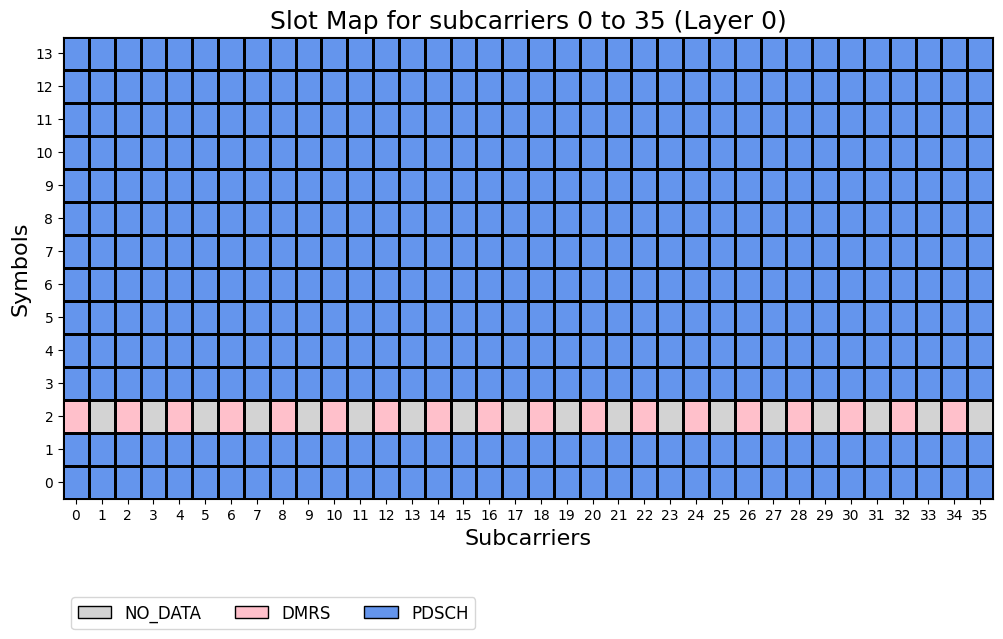

In [9]:
grid.drawMap(reRange=(0,36))

## MIMO Precoding
Now we can apply precoding to the our data grid. Assuming 4 transmit antenna, we create a simple precoding matrix which is based on Identity matrix. We then call the `precode` method of `grid` to get the precoded grid.

In [10]:
numTxAntenna = 4
w = np.fft.fft(np.eye(numTxAntenna))/np.sqrt(numTxAntenna)
# Get a sub-matrix by using only the frist 'numLayers' rows and normalize it accordingly.
w = w[:pdsch.numLayers,:]/np.sqrt(pdsch.numLayers)

w.shape,w

((2, 4),
 array([[ 0.35355339+0.j        ,  0.35355339+0.j        ,
          0.35355339+0.j        ,  0.35355339+0.j        ],
        [ 0.35355339+0.j        ,  0.        -0.35355339j,
         -0.35355339+0.j        ,  0.        +0.35355339j]]))

In [11]:
precodedGrid = grid.precode(w.T)
grid.shape, w.shape, precodedGrid.shape

((2, 14, 624), (2, 4), (4, 14, 624))

We can now compare these results with the ones printed by the Matlab program `Mapping5GPhysicalChannelsAndSignalsToTheResourceGridExample.mlx`.

In [12]:
pdschGridMatlab = scipy.io.loadmat(matlabFilesPath + '/pdschGrid.mat')['pdschGrid']
pdschGridMatlab = np.transpose(pdschGridMatlab, (2,1,0)) # Matlab uses a different order
assert np.abs(pdschGridMatlab-precodedGrid.grid).max()<1e-10, "MISMATCH WITH MATLAB!!!"

# Print the first 10 Data Symbols:
print("Precoded Grid:\n", np.round(precodedGrid[0,0,:10],4))
print("Matlab-Generated Precoded Grid:\n", np.round(pdschGridMatlab[0,0,:10],4))

Precoded Grid:
 [ 0.2236+0.4472j -0.2236-0.6708j -0.2236-0.2236j  0.2236+0.j
  0.4472-0.2236j  0.4472+0.j      0.6708+0.j     -0.6708-0.4472j
 -0.2236+0.j     -0.4472+0.j    ]
Matlab-Generated Precoded Grid:
 [ 0.2236+0.4472j -0.2236-0.6708j -0.2236-0.2236j  0.2236-0.j
  0.4472-0.2236j  0.4472-0.j      0.6708+0.j     -0.6708-0.4472j
 -0.2236-0.j     -0.4472+0.j    ]


## OFDM Modulation
Now we call the `ofdmModulate` method of our `precodedGrid` object to get the output waveform for each antenna and compare these results with the ones printed by the Matlab program `Mapping5GPhysicalChannelsAndSignalsToTheResourceGridExample.mlx`.

In [13]:
waveForm = precodedGrid.ofdmModulate()
waveForm.print()
waveformMatlab = scipy.io.loadmat(matlabFilesPath + '/txWaveform.mat')['txWaveform'].T
assert np.abs(waveForm[:]-waveformMatlab).max()<1e-10, \
    "MISMATCH WITH MATLAB!!! (max Diff: %f)"%(np.abs(waveForm-waveformMatlab).max())

# print the first 10 samples of the waveForm for first TX antenna
print("Waveform Data:\n", np.round(waveForm[0,:10],4))
print("Matlab-Generated Waveform Data:\n", np.round(waveformMatlab[0,:10],4))


Waveform Properties:
  Number of Ports: 4
  Length: 15360

Waveform Data:
 [ 0.0053-0.0104j  0.0072+0.0016j -0.0017+0.0071j -0.0086-0.0011j
  0.0063-0.0057j  0.0191-0.0001j  0.0044+0.004j  -0.015 +0.0036j
 -0.0155+0.0084j -0.008 +0.015j ]
Matlab-Generated Waveform Data:
 [ 0.0053-0.0104j  0.0072+0.0016j -0.0017+0.0071j -0.0086-0.0011j
  0.0063-0.0057j  0.0191-0.0001j  0.0044+0.004j  -0.015 +0.0036j
 -0.0155+0.0084j -0.008 +0.015j ]


Text(0.5, 1.0, 'Magnitude of the time-domain waveform for the first antenna')

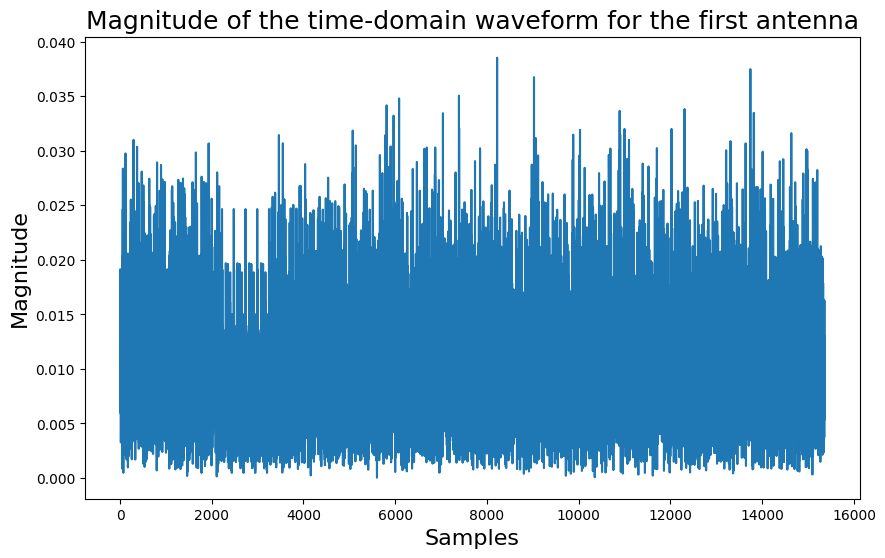

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(np.abs(waveForm[0]))
plt.xlabel("Samples", fontsize=16)
plt.ylabel("Magnitude", fontsize=16)
plt.title("Magnitude of the time-domain waveform for the first antenna", fontsize=18)
